In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

import sys

from helper import unet
import tensorflow as tf

from keras import backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Flatten, Dropout

2025-04-07 16:53:25.592101: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 16:53:25.783001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744037605.855748   17087 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744037605.875329   17087 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744037606.018522   17087 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
def load_images(image_dir, mask_dir):
    images, masks = [], []

    for file in os.listdir(image_dir):
        if file.endswith('.jpg'):
            image = cv2.imread(image_dir + file,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128,128))
            images.append(image)
    for file in os.listdir(mask_dir):
        if file.endswith('.png'):
            mask = cv2.imread(mask_dir + file,cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (128, 128))
            masks.append(mask)
    return images, masks

In [4]:
images, masks = load_images("data/images/", "data/masks/")
print(len(images))
print(len(masks))

10015
10015


In [9]:
def plot_images(images, masks,num):
    plt.figure(figsize=(18, 9))
    for i in range(num):
        idx = random.randint(0, len(images))
        img = images[idx]
        mask = masks[idx]
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')
        plt.subplot(2, 4, i + num + 1)
        plt.imshow(mask)
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')
        del img, mask


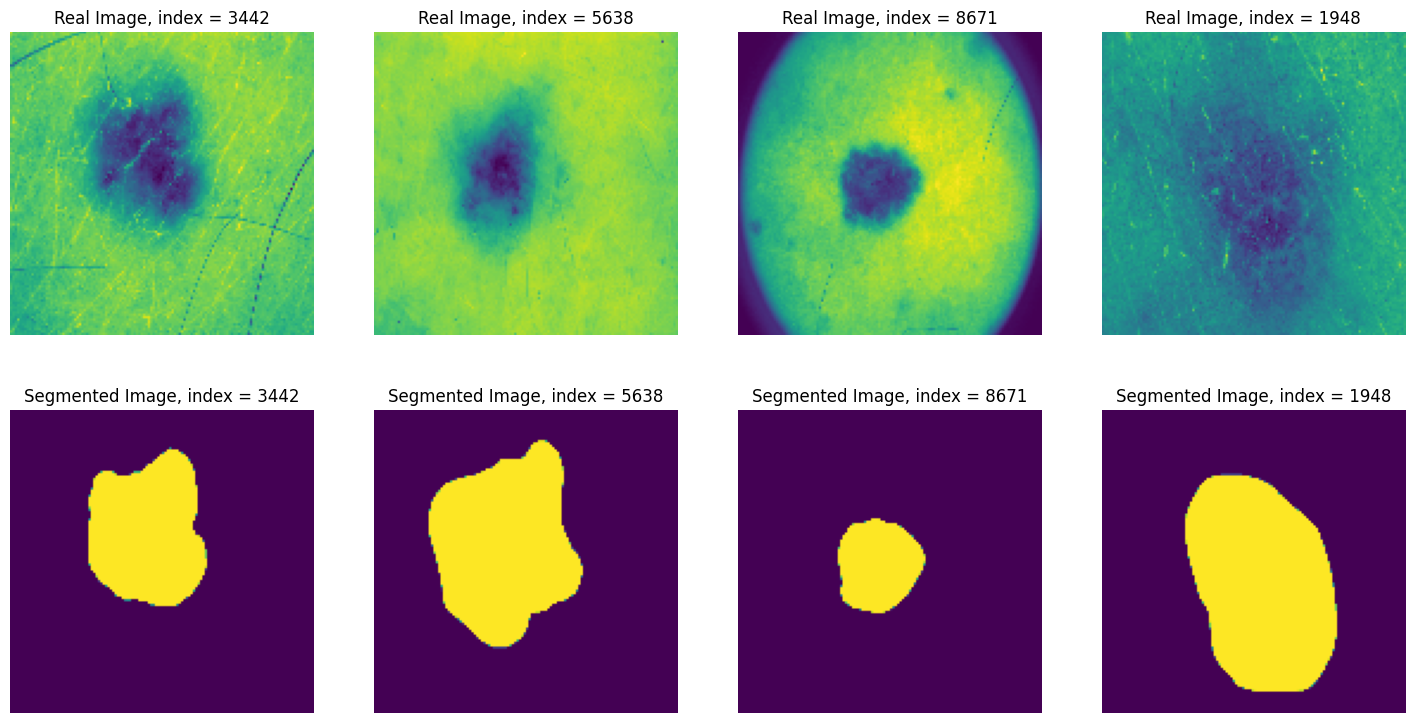

In [10]:
plot_images(images, masks,4)

In [11]:
def to_tensor(image_list, mask_list):
    tensor_images = tf.convert_to_tensor(tf.cast(np.array(image_list),  dtype = tf.float32))/255
    tensor_masks = tf.convert_to_tensor(tf.cast(np.array(mask_list), dtype= tf.float32))/255
    return tensor_images, tensor_masks

In [12]:
images, masks = to_tensor(images, masks)

I0000 00:00:1744037938.702822   17087 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
#splitting the images and masks into train, test and split
train_split = tf.cast(tf.round(len(images)*0.6) - 1, dtype = tf.int32)
test_val_split = tf.cast(tf.round(len(images)*0.2), dtype = tf.int32)

images_train = images[:train_split]
masks_train = masks[:train_split]

images_val = images[train_split:train_split + test_val_split]
masks_val = masks[train_split:train_split + test_val_split]

images_test = images[train_split + test_val_split:]
masks_test = masks[train_split + test_val_split:]

del images, masks

print(f'The length of images and masks for training is {len(images_train)} and {len(masks_train)} respectively')
print(f'The length of images and masks for validation is {len(images_val)} and {len(masks_val)} respectively')
print(f'The length of images and masks for testing is {len(images_test)} and {len(masks_test)} respectively')

The length of images and masks for training is 6008 and 6008 respectively
The length of images and masks for validation is 2003 and 2003 respectively
The length of images and masks for testing is 2004 and 2004 respectively


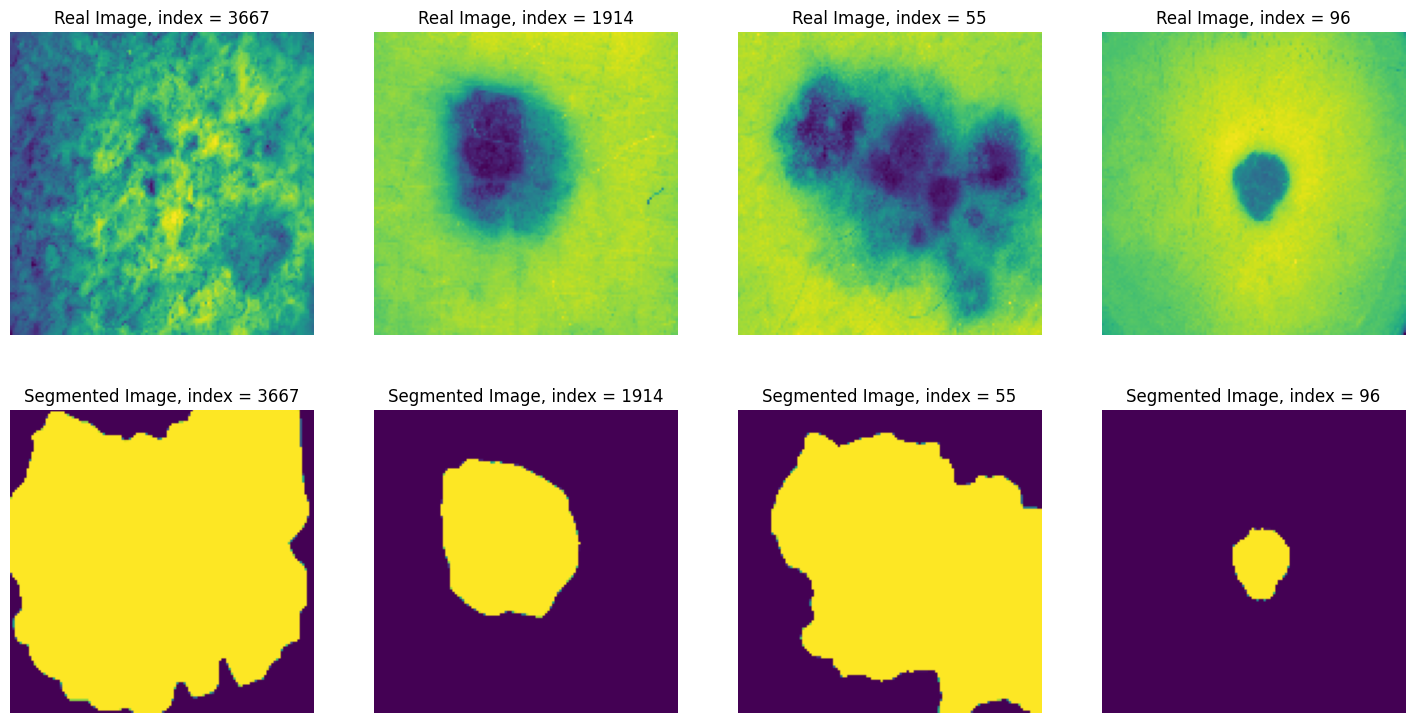

In [14]:
plot_images(images_train, masks_train,4)

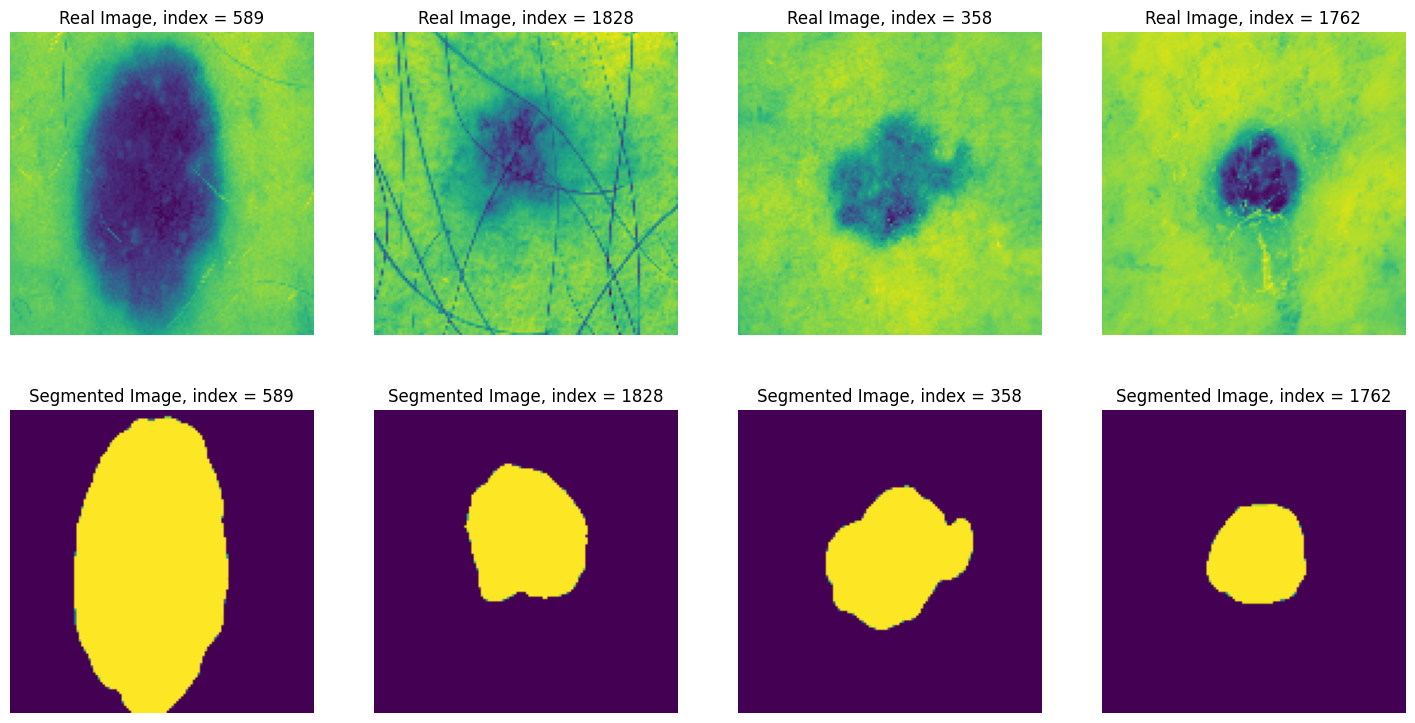

In [15]:
plot_images(images_val, masks_val,4)

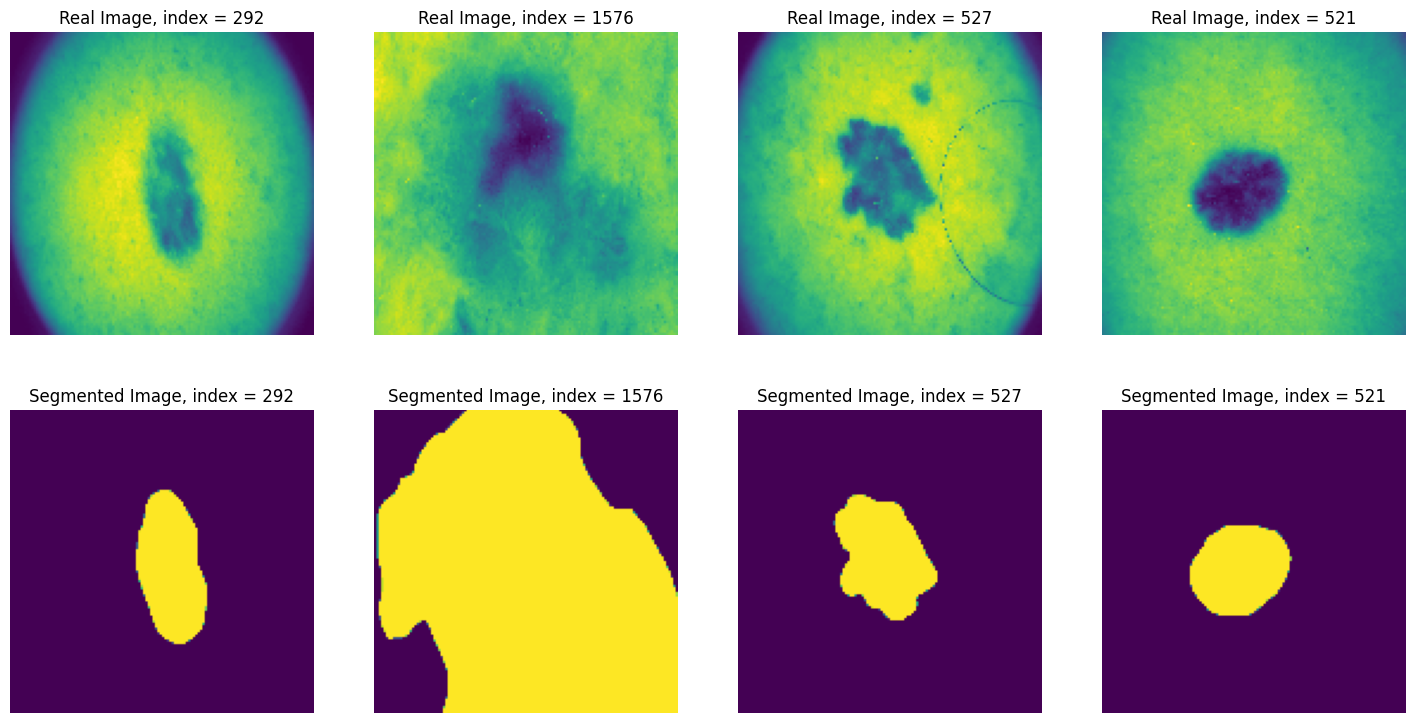

In [16]:
plot_images(images_test, masks_test,4)

In [17]:
#Converting the list of tensors into batches to efficiently train the model, computation-wise
batch_size = 5

train_data = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
val_data = val_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_data = test_data.batch(batch_size)

In [18]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [19]:
unet = unet()
unet.compile(loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy', dice_coefficient])
unet.summary()

Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 25,808,193 (98.45 MB)

 Trainable params: 25,808,193 (98.45 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [21]:
unet_history = unet.fit(train_data,validation_data=[val_data],
                        epochs = 50, callbacks = [early_stopping])

Epoch 1/50


I0000 00:00:1744037991.383434   18100 service.cc:152] XLA service 0x7fd3e4013f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744037991.383487   18100 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-07 16:59:51.485953: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744037992.096245   18100 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-07 16:59:58.749491: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng65{k2=1,k5=3,k14=2} for conv %cudnn-conv-bw-input.37 = (f32[5,256,33,33]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,256,32,32]{3,2,1,0} %bitcast.11459, f32[256,256,2,2]{3,2,1,0} %bitcast.11396), window={size=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", metadata={op_type="Conv2DBac

1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8298 - dice_coefficient: 0.5183 - loss: 0.3859

2025-04-07 17:01:24.520679: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 8 bytes spill stores, 8 bytes spill loads



1202/1202 ━━━━━━━━━━━━━━━━━━━━ 108s 75ms/step - accuracy: 0.8299 - dice_coefficient: 0.5184 - loss: 0.3858 - val_accuracy: 0.8672 - val_dice_coefficient: 0.6324 - val_loss: 0.3385
Epoch 2/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 94s 78ms/step - accuracy: 0.9082 - dice_coefficient: 0.7322 - loss: 0.2389 - val_accuracy: 0.9237 - val_dice_coefficient: 0.8051 - val_loss: 0.1755
Epoch 3/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 108s 90ms/step - accuracy: 0.9377 - dice_coefficient: 0.8279 - loss: 0.1540 - val_accuracy: 0.9406 - val_dice_coefficient: 0.8396 - val_loss: 0.1419
Epoch 4/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 96s 80ms/step - accuracy: 0.9442 - dice_coefficient: 0.8477 - loss: 0.1362 - val_accuracy: 0.9469 - val_dice_coefficient: 0.8576 - val_loss: 0.1267
Epoch 5/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 81s 68ms/step - accuracy: 0.9489 - dice_coefficient: 0.8612 - loss: 0.1234 - val_accuracy: 0.9489 - val_dice_coefficient: 0.8700 - val_loss: 0.1226
Epoch 6/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 78s 65ms/step - a

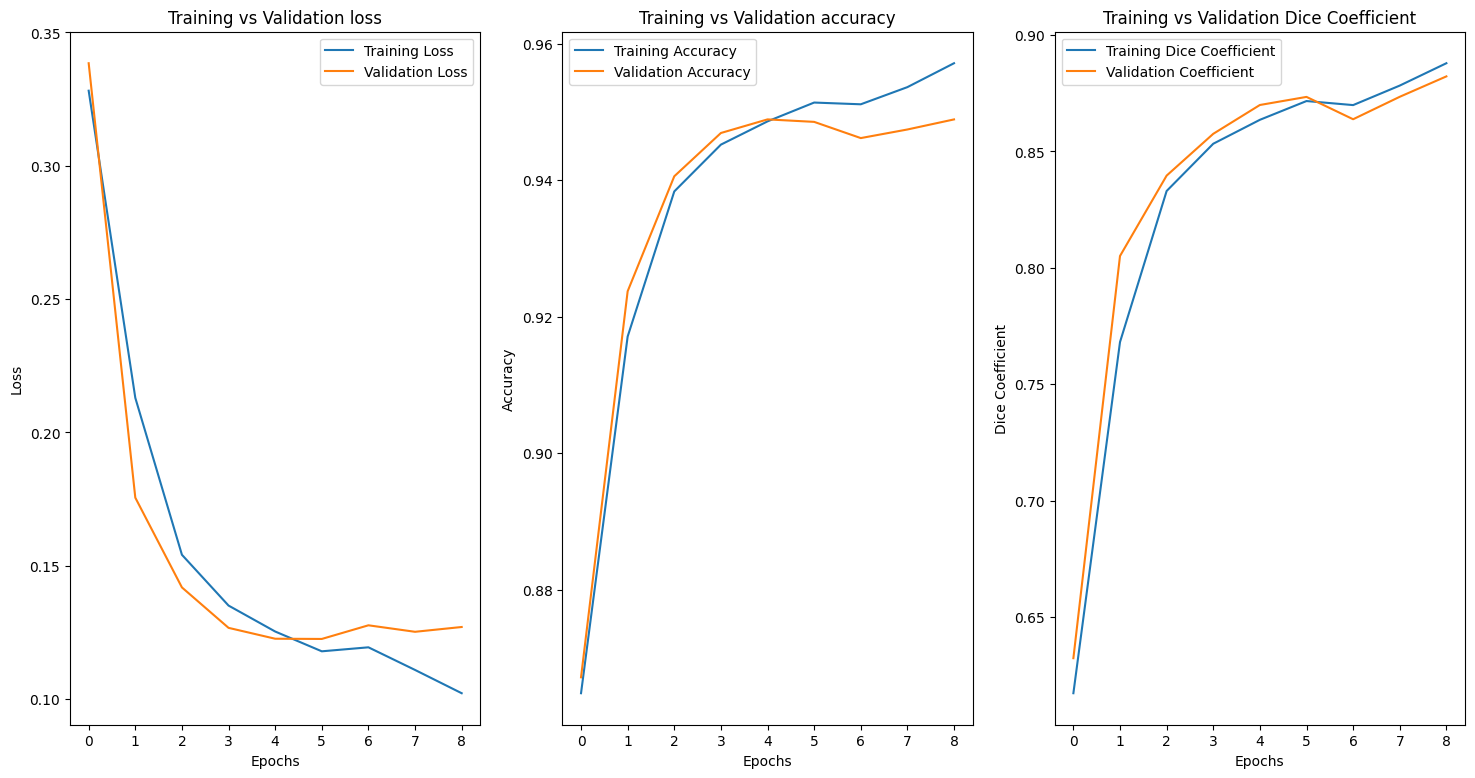

In [23]:
#Plotting the loss and accuracy during training and validation
plt.figure(figsize = (18, 9))
plt.subplot(1,3,1)
plt.plot(unet_history.history['loss'])
plt.plot(unet_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.subplot(1,3,2)
plt.plot(unet_history.history['accuracy'])
plt.plot(unet_history.history['val_accuracy'])
plt.title('Training vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.subplot(1,3,3)
plt.plot(unet_history.history['dice_coefficient'])
plt.plot(unet_history.history['val_dice_coefficient'])
plt.title('Training vs Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['Training Dice Coefficient', 'Validation Coefficient'])

In [24]:
unet.evaluate(test_data)

401/401 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9602 - dice_coefficient: 0.8993 - loss: 0.0971


[0.09472331404685974, 0.9615143537521362, 0.8986429572105408]

In [25]:
#Function to plot the predictions with orginal image, original mask and predicted mask
def plot_preds(idx):
    plt.figure(figsize = (15, 15))
    test_img = images_test[idx]
    test_img = tf.expand_dims(test_img, axis = 0)
    test_img = tf.expand_dims(test_img, axis = -1)
    pred = unet.predict(test_img)
    pred = pred.squeeze()
    thresh = pred > 0.5
    plt.subplot(1,3,1)
    plt.imshow(images_test[idx])
    plt.title(f'Original Image {idx}')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks_test[idx])
    plt.title('Actual Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(thresh)
    plt.title('Predicted Mask')
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


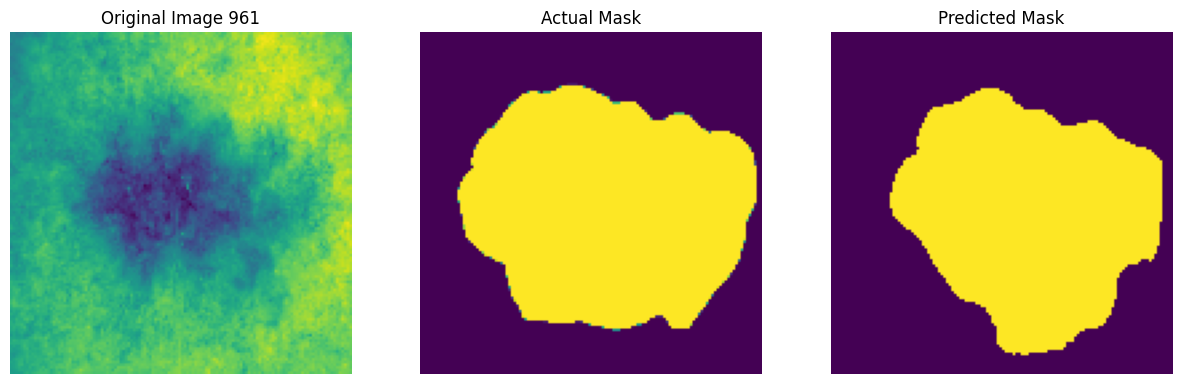

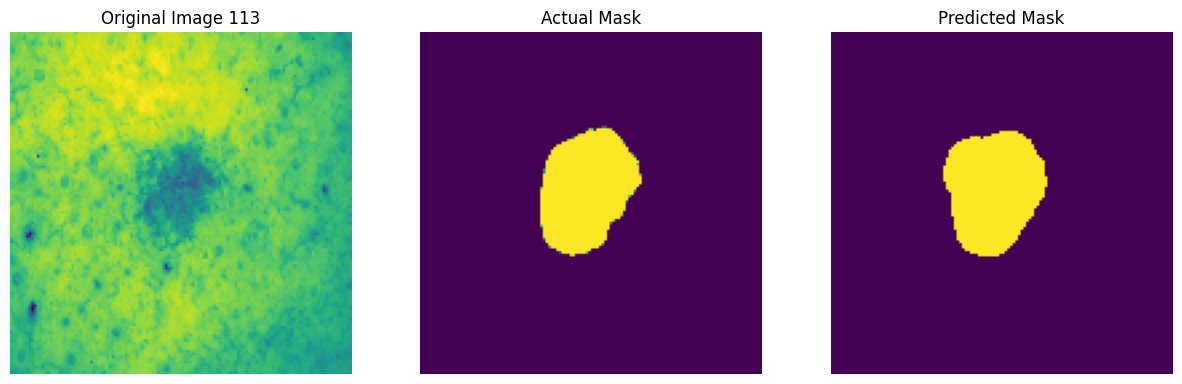

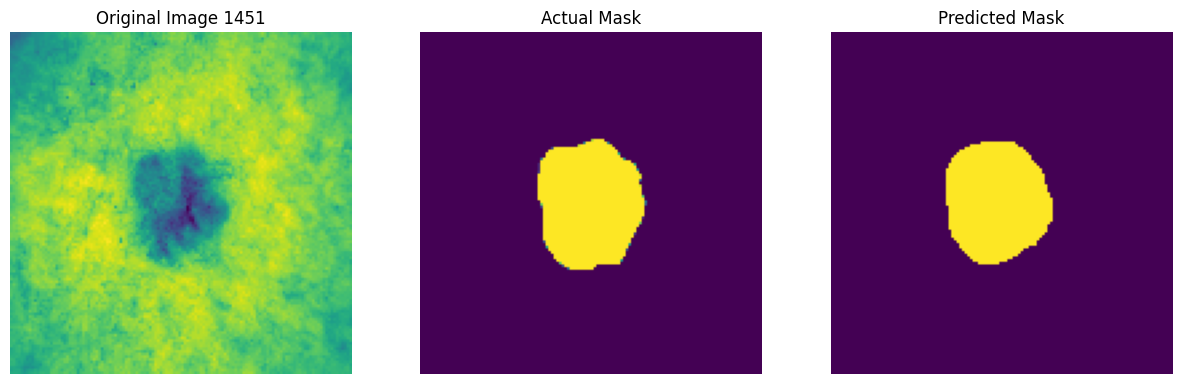

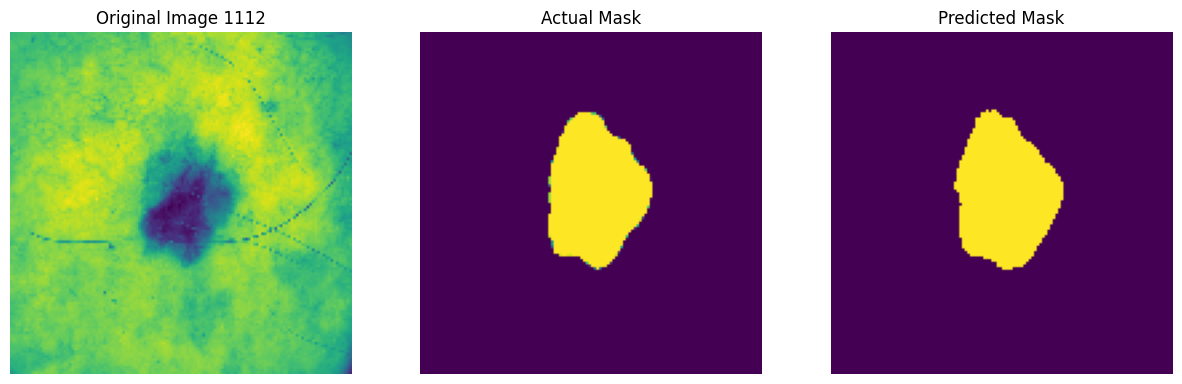

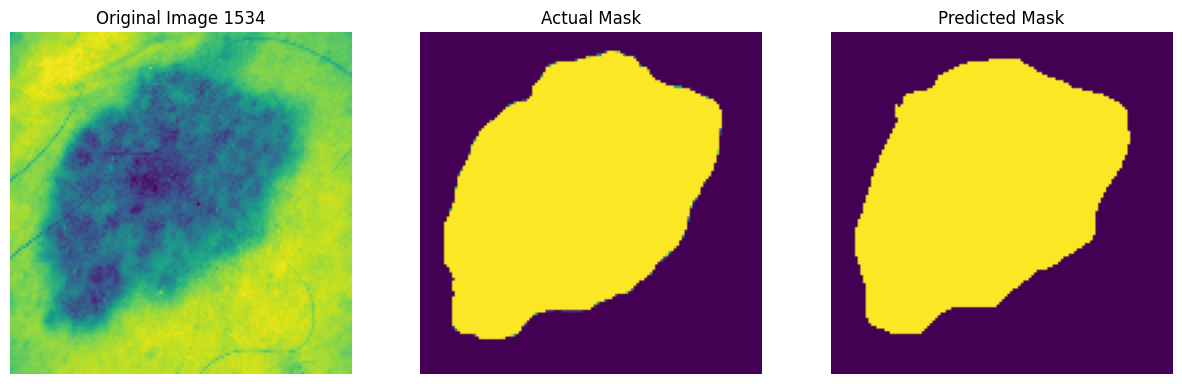

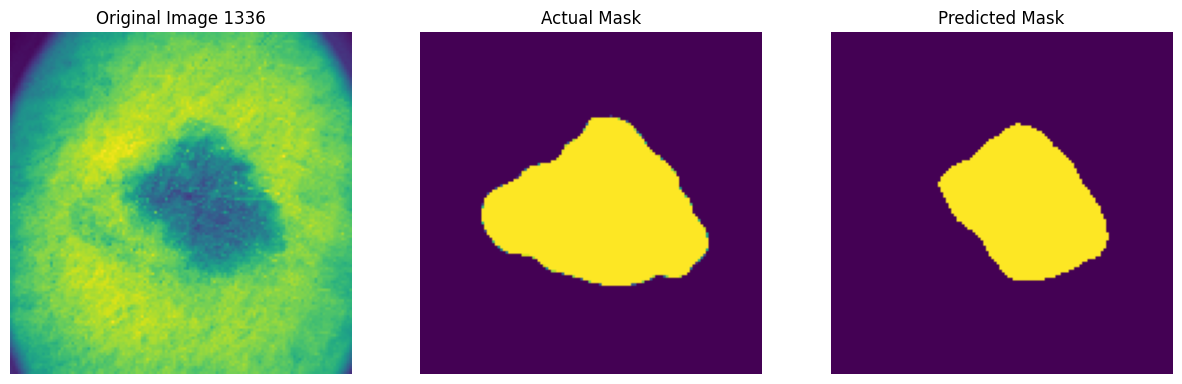

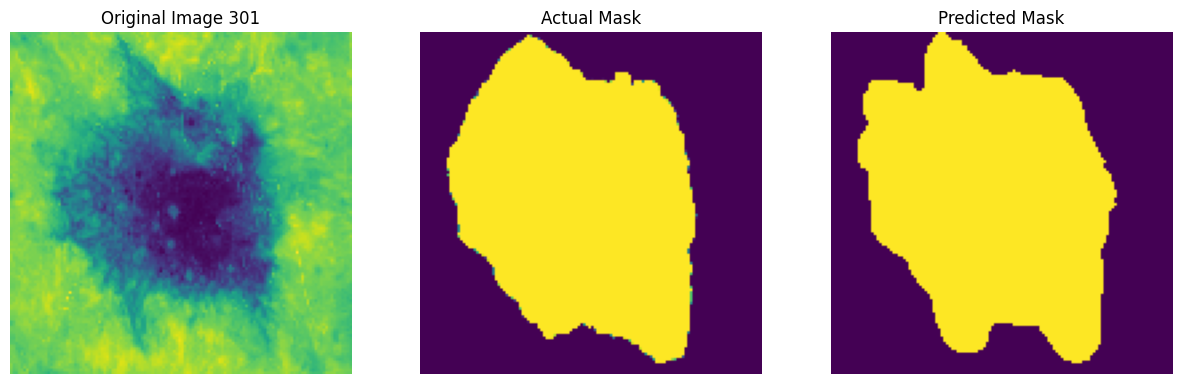

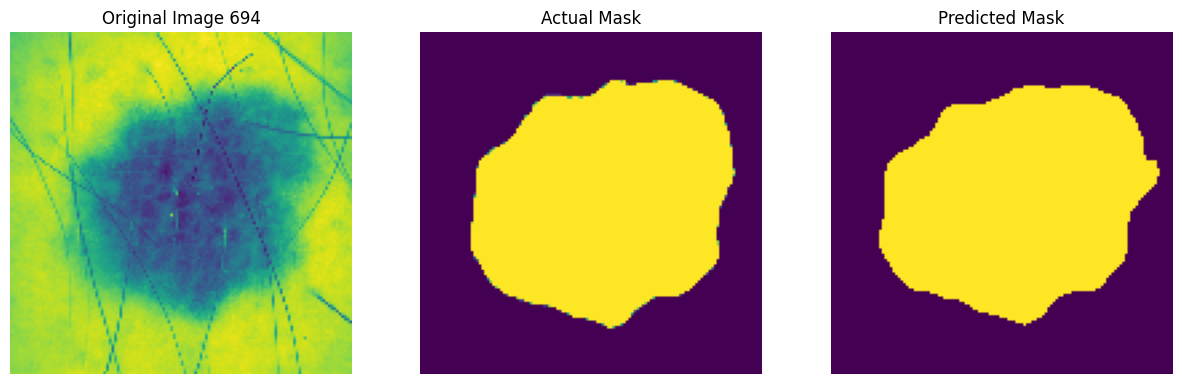

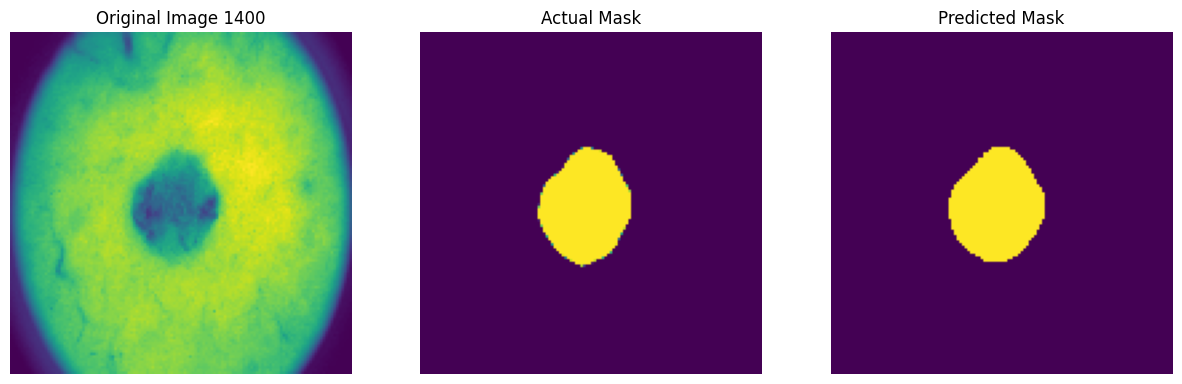

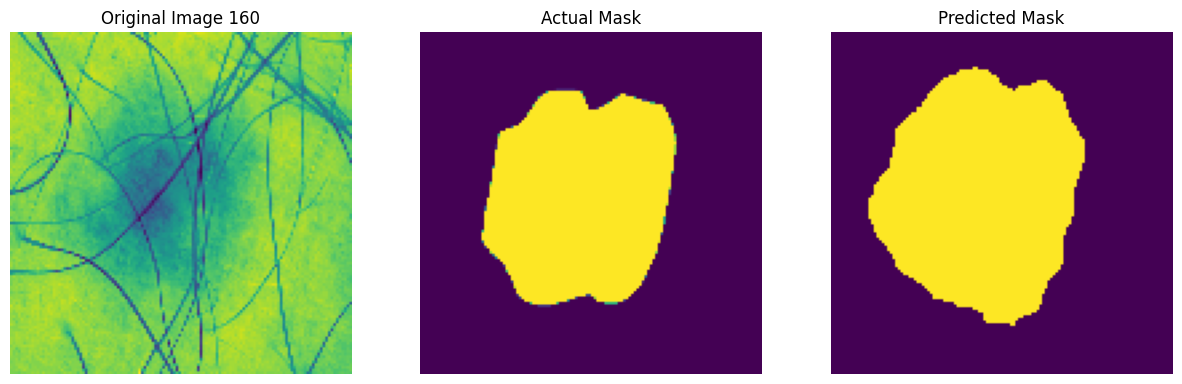

In [26]:
for i in [random.randint(0, 2000) for i in range(10)]:
    plot_preds(i)

In [28]:
#Saving the model
unet.save('unet_model.keras')